# PSD

author: steeve.laquitaine@epfl.ch

## Setup

1. Setup `spikebias` virtual environment

2. Compute the power spectral densities of the full recordings   

    a. with multi-nodes multi-core processing: 

    - python src/pipes/validation/psd/mpi_dense_full.py
    - python src/pipes/validation/psd/mpi_npx_full.py

    b. Or on a single node: 

    - python src/pipes/validation/psd/multiproc_dense_probe1.py
    - python src/pipes/validation/psd/multiproc_dense_probe2.py
    - python src/pipes/validation/psd/multiproc_dense_probe3.py
    - python src/pipes/validation/psd/multiproc_horvath_probe1.py
    - python src/pipes/validation/psd/multiproc_horvath_probe2.py
    - python src/pipes/validation/psd/multiproc_horvath_probe3.py


TODO:
- download horvath and dense probes
- run AP psds horvath and simulations for both as they will be rescaled

In [ ]:
# import libs
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

import os
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import spikeinterface as si
import copy
import multiprocessing
import torch
import seaborn as sns
import pandas as pd
from scipy.stats import kruskal # stats
import scikit_posthocs as sp

# move to PROJECT PATH
PROJ_PATH = "/home/steeve/steeve/epfl/code/spikebias"
os.chdir(PROJ_PATH)

# import custom package
from src.nodes.validation import power

matplotlib.rcParams['agg.path.chunksize'] = 10000

# SETUP PARAMETERS
prm = dict()
prm["SFREQ_HV"] = 20000        # sampling frequency
prm["SFREQ_HS"] = 20000        # sampling frequency

# setup paths

RAW_PATH_hv1 =  "dataset/00_raw/recording_horvath_probe1"
PRE_PSD_PATH_HV1 = "dataset/01_intermediate/psds/psd_prep_horvath_probe1.npy"
RAW_PATH_hv2 =  "dataset/00_raw/recording_horvath_probe2"
PRE_PSD_PATH_HV2 = "dataset/01_intermediate/psds/psd_prep_horvath_probe2.npy"
RAW_PATH_hv3 =  "dataset/00_raw/recording_horvath_probe3"
PRE_PSD_PATH_HV3 = "dataset/01_intermediate/psds/psd_prep_horvath_probe3.npy"
RAW_PATH_hs1 = "dataset/00_raw/recording_dense_probe1"
PRE_PSD_PATH_HS1 = "dataset/01_intermediate/psds/psd_prep_dense_probe1.npy"
RAW_PATH_hs2 = "dataset/00_raw/recording_dense_probe2"
PRE_PSD_PATH_HS2 ="dataset/01_intermediate/psds/psd_prep_dense_probe2.npy"
RAW_PATH_hs3 = "dataset/00_raw/recording_dense_probe3"
PRE_PSD_PATH_HS3 = "dataset/01_intermediate/psds/psd_prep_dense_probe3.npy"

## pipeline parameters
SAVE_FIG = True
SAVE_TEMP_DATA = True
LOAD_TEMP_DATA = False

# setup intermediate dataset path
PLOT_DATA_PATH_DENSE = "dataset/02_figure_dataset/fig2s_data_APpower_dense.parquet"

# FIGURE SETTINGS
FIG_SIZE = (1.5, 1.5)
# experiment colors
cl = dict()
cl["COLOR_NV"] = [0.6, 0.6, 0.6]
cl["COLOR_NS"] = [0.9, 0.14, 0.15]
cl["COLOR_NB"] = [0.22, 0.5, 0.72] # blue
cl["COLOR_NE"] = [1, 0.49, 0] # orange
cl["COLOR_MEDIAN"] = (1, 0.76, 0)
cl["COLOR_HV"] = "k" # black
cl["COLOR_HS"] = np.array([26, 152, 80]) / 255 # green

# axes aesthetics
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 6  # 5-7 with Nature neuroscience as reference
plt.rcParams["lines.linewidth"] = 0.5 # typically 0.5 - 1 pt
plt.rcParams["axes.linewidth"] = 0.5 # typically 0.5 - 1 pt
plt.rcParams["axes.spines.top"] = False
plt.rcParams["xtick.major.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["xtick.minor.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["ytick.major.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["ytick.minor.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["xtick.major.size"] = 3.5 * 1.1
plt.rcParams["xtick.minor.size"] = 2 * 1.1
plt.rcParams["ytick.major.size"] = 3.5 * 1.1
plt.rcParams["ytick.minor.size"] = 2 * 1.1
N_MAJOR_TICKS = 4
N_MINOR_TICKS = 12
savefig_cfg = {"transparent":True, "dpi":300}
legend_cfg = {"frameon": False, "handletextpad": 0.1}
tight_layout_cfg = {"pad": 0.5}
LG_FRAMEON = False              # no legend frame

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Clear RAM

In [5]:
import getpass; password = getpass.getpass("Enter your sudo password: ")
!sync; echo {password} | sudo -S sh -c 'echo 1 > /proc/sys/vm/drop_caches'

[sudo] password for steeve: 

## (1s)Load datasets

* select first 10 min for speed

In [ ]:
# Load traces
RawHV1 = si.load_extractor(RAW_PATH_hv1)
RawHS1 = si.load_extractor(RAW_PATH_hs1)
RawHV2 = si.load_extractor(RAW_PATH_hv2)
RawHS2 = si.load_extractor(RAW_PATH_hs2)
RawHV3 = si.load_extractor(RAW_PATH_hv3)
RawHS3 = si.load_extractor(RAW_PATH_hs3)

# get good sites (in cortex)

# dense probe 1 (select L1, L2/3)
site_ly_hs1 = RawHS1.get_property("layers")
site_ly_hs1 = np.array(["L2_3" if x == "L2" or x == "L3" else x for x in site_ly_hs1])
sites_hs1 = np.where(np.isin(site_ly_hs1, ["L1", "L2_3"]))[0]
# dense probe 2 (select L4 and L5)
site_ly_hs2 = RawHS2.get_property("layers")
sites_hs2 = np.where(np.isin(site_ly_hs2, ["L4", "L5"]))[0]
# dense probe 3 (select L6)
site_ly_hs3 = RawHS3.get_property("layers")
site_ly_hs3 = np.array(["L2_3" if x == "L2" or x == "L3" else x for x in site_ly_hs3])
sites_hs3 = np.where(np.isin(site_ly_hs3, ["L6"]))[0]

# viv
# horvath probe 1
site_ly_hv1 = RawHV1.get_property("layers")
sites_hv1 = np.where(np.isin(site_ly_hv1, ["L1", "L2_3"]))[0]
# horvath probe 2
site_ly_hv2 = RawHV2.get_property("layers")
sites_hv2 = np.where(np.isin(site_ly_hv2, ["L4", "L5"]))[0]
# horvath probe 3
site_ly_hv3 = RawHV3.get_property("layers")
sites_hv3 = np.where(np.isin(site_ly_hv3, ["L6"]))[0]

# Load pre-computed PSDs (in cortex)
# preprocessed
psd_pre_hv1 = np.load(PRE_PSD_PATH_HV1, allow_pickle=True).item()
psd_pre_hv2 = np.load(PRE_PSD_PATH_HV2, allow_pickle=True).item()
psd_pre_hv3 = np.load(PRE_PSD_PATH_HV3, allow_pickle=True).item()
psd_pre_hs1 = np.load(PRE_PSD_PATH_HS1, allow_pickle=True).item()
psd_pre_hs2 = np.load(PRE_PSD_PATH_HS2, allow_pickle=True).item()
psd_pre_hs3 = np.load(PRE_PSD_PATH_HS3, allow_pickle=True).item()

# unit-test
assert psd_pre_hv1["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_pre_hv2["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_pre_hv3["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_pre_hs1["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_pre_hs2["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_pre_hs3["freq"][1] == 1.0, "psd resolution should be 1Hz"

### SAVE TEMP DATA

In [30]:
FIG_SIZE = (1.8, 1)

NORM = False

# calculate stats and plot data
d1 = power.get_psd_data_prepro_dense("L1", psd_pre_hv1, psd_pre_hs1, site_ly_hv1[sites_hv1], site_ly_hs1[sites_hs1], norm=NORM)
d23 = power.get_psd_data_prepro_dense("L2_3", psd_pre_hv1, psd_pre_hs1, site_ly_hv1[sites_hv1], site_ly_hs1[sites_hs1], norm=NORM)
d4 = power.get_psd_data_prepro_dense("L4", psd_pre_hv2, psd_pre_hs2, site_ly_hv2[sites_hv2], site_ly_hs2[sites_hs2], norm=NORM)
d5 = power.get_psd_data_prepro_dense_layer_5("L5", psd_pre_hv2, psd_pre_hs2, site_ly_hv2[sites_hv2], site_ly_hs2[sites_hs2], norm=NORM)
d6 = power.get_psd_data_prepro_dense("L6", psd_pre_hv3, psd_pre_hs3, site_ly_hv3[sites_hv3], site_ly_hs3[sites_hs3], norm=NORM)

## (1s)AP power (dense probe)

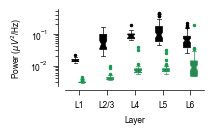

In [31]:
c_bot = 300  # spike with a period of 3 ms
c_up = 1000  # spike with a period of 0.5 ms

# Marques-Smith
df_hv1 = power.get_spiking_power(d1["psd_pre_hv_"], c_bot, c_up, "H", "L1")
df_hv23 = power.get_spiking_power(d23["psd_pre_hv_"], c_bot, c_up, "H", "L2_3")
df_hv4 = power.get_spiking_power(d4["psd_pre_hv_"], c_bot, c_up, "H", "L4")
df_hv5 = power.get_spiking_power(d5["psd_pre_hv_"], c_bot, c_up, "H", "L5")
df_hv6 = power.get_spiking_power(d6["psd_pre_hv_"], c_bot, c_up, "H", "L6")

# npx spontaneous
df_hs1 = power.get_spiking_power(d1["psd_pre_hs_"], c_bot, c_up, "DS", "L1")
df_hs23 = power.get_spiking_power(d23["psd_pre_hs_"], c_bot, c_up, "DS", "L2_3")
df_hs4 = power.get_spiking_power(d4["psd_pre_hs_"], c_bot, c_up, "DS", "L4")
df_hs5 = power.get_spiking_power(d5["psd_pre_hs_"], c_bot, c_up, "DS", "L5")
df_hs6 = power.get_spiking_power(d6["psd_pre_hs_"], c_bot, c_up, "DS", "L6")

# stack
plot_df_dense = pd.concat(
    [
        df_hv1,
        df_hv23,
        df_hv4,
        df_hv5,
        df_hv6,
        df_hs1,
        df_hs23,
        df_hs4,
        df_hs5,
        df_hs6,
    ]
)

# standardize
plot_df_dense["Layer"][plot_df_dense["Layer"] == "L2_3"] = "L2/3"

# plot
fig, ax = plt.subplots(1, 1, figsize=FIG_SIZE)

ax = sns.boxplot(
    ax=ax,
    data=plot_df_dense,
    x="Layer",
    y="power",
    hue="Experiment",
    notch=True,
    hue_order=["H", "DS"],
    palette=[cl["COLOR_HV"], cl["COLOR_HS"]],
    width=0.5,
    linewidth=0.5,
    flierprops={
        "marker": ".",
        "markersize": 3,
    },
)
ax.set_yscale("log")

# axes
ax.spines[["top", "right"]].set_visible(False)
ax.legend("", frameon=False)

# minor ticks
locmin = matplotlib.ticker.LogLocator(
    base=10.0,
    subs=np.arange(0, 1.1, 0.1),
    numticks=10,
)
ax.tick_params(which="both")
ax.yaxis.set_minor_locator(locmin)

# disconnect axes (R style)
ax.spines["bottom"].set_position(("axes", -0.05))
ax.yaxis.set_ticks_position("left")
ax.spines["left"].set_position(("axes", -0.05))

# ax.legend("", frameon=False)
ax.set_ylabel("Power ($\u03bcV^2$/Hz)")
ax.set_xlabel("Layer")
# ax.set_ylim([1.4, 3.7])


# customize the boxplot
p = 0
for box in ax.patches:
    if box.__class__.__name__ == "PathPatch":
        # a list item for each layer group
        if p in [0, 1, 2, 3, 4]:
            # Each box has 6 associated Line2D objects
            # (to make the whiskers, fliers, etc.)
            # Loop over them here, and use the same colour
            # as above
            # group 1 (NV)
            box.set_edgecolor(cl["COLOR_HV"])
            for k in range(6 * p, 6 * (p + 1)):
                ax.lines[k].set_color(cl["COLOR_HV"])  # box
                ax.lines[k].set_mfc(cl["COLOR_HV"])  # whisker
                ax.lines[k].set_mec(cl["COLOR_HV"])  # fliers
            p += 1
        elif p in [5, 6, 7, 8, 9]:
            # group 2 (DS)
            box.set_edgecolor(cl["COLOR_HS"])
            for k in range(6 * p, 6 * (p + 1)):
                ax.lines[k].set_color(cl["COLOR_HS"])
                ax.lines[k].set_mfc(cl["COLOR_HS"])
                ax.lines[k].set_mec(cl["COLOR_HS"])
            p += 1

# save
if SAVE_FIG: plt.savefig("figures/0_validation/4_power/fig2U/fig2U_AP_power_dense.svg", **savefig_cfg)

### SAVE TEMP data

In [33]:
# save plot and statistics data
if SAVE_TEMP_DATA:
    plot_df_dense.to_parquet(PLOT_DATA_PATH_DENSE)
    print("Saved here:", PLOT_DATA_PATH_DENSE)
elif LOAD_TEMP_DATA:
    plot_df_dense = pd.read_parquet(PLOT_DATA_PATH_DENSE)

Saved here: dataset/02_figure_dataset/fig2s_data_APpower_dense.parquet


### Hypothesis testing

In [34]:
def get_power(df, exp, layer):
    return df[(df.Experiment == exp) & (df.Layer == layer)]["power"].values


def get_kk(df, exp):
    """kruskall wallis test"""
    h, p = kruskal(
        get_power(df, exp, "L1"),
        get_power(df, exp, "L2/3"),
        get_power(df, exp, "L4"),
        get_power(df, exp, "L5"),
        get_power(df, exp, "L6"),
    )

    print(f"H={h}, p={p}")
    print(f"""N_L1 = {len(get_power(df, exp, "L1"))} sites""")
    print(f"""N_L23 = {len(get_power(df, exp, "L2/3"))} sites""")
    print(f"""N_L4 = {len(get_power(df, exp, "L4"))} sites""")
    print(f"""N_L5 = {len(get_power(df, exp, "L5"))} sites""")
    print(f"""N_L6 = {len(get_power(df, exp, "L6"))} sites""")


def get_posthoc_dunn_holm_sidak(df, exp):
    """posthoc test after kruskall wallis with Dunn and holm_sidak
    multiple comparison correction of p-values

    Args:
        df (_type_): _description_
        exp (_type_): _description_

    Returns:
        _type_: _description_
    """
    data = [
        get_power(df, exp, "L1"),
        get_power(df, exp, "L2/3"),
        get_power(df, exp, "L4"),
        get_power(df, exp, "L5"),
        get_power(df, exp, "L6"),
    ]
    # holm sidak method has more power than Bonferroni which is more conservative
    # Non-significance can indicate subtle differences, power issues, samll sample size,
    # or the balancing be due to how the Holm-Sidak correction controls Type I errors
    # while retaining power.
    # we can still look at the p-values to identify trends.
    df = sp.posthoc_dunn(data, p_adjust="holm-sidak")
    df.columns = ["L1", "L2/3", "L4", "L5", "L6"]
    df.index = ["L1", "L2/3", "L4", "L5", "L6"]
    return df

def ci95(data):
    return 1.96 * np.nanstd(data) / np.sqrt(np.sum(~np.isnan(data)))

def get_medians_and_ci95(plot_data, exp, feature: str):
    layers = ["L1", "L2/3", "L4", "L5", "L6"]
    stats = ""
    record = []
    for layer in layers:
        feature_data = plot_data[(plot_data.Experiment==exp) & (plot_data.Layer==layer)][feature]
        stats += f"{np.round(feature_data.median()*10000)/10000} $\pm$ {np.round(ci95(feature_data),6)}, "
        record.append(np.round(feature_data.median()*10000)/10000)
    print(stats)
    return record

### Power changes across layers?

DENSE

In [35]:
# standardize layer
print("\n--------------------H--------------------\n")
plot_df_dense.Layer[plot_df_dense.Layer == "L2_3"] = "L2/3"
get_kk(plot_df_dense, "H")
display(get_posthoc_dunn_holm_sidak(plot_df_dense, "H"))
m_h = get_medians_and_ci95(plot_df_dense, "H", "power") 

print("\n--------------------DS--------------------\n")

get_kk(plot_df_dense, "DS")
display(get_posthoc_dunn_holm_sidak(plot_df_dense, "DS"))
m_ds = get_medians_and_ci95(plot_df_dense, "DS", "power")


--------------------H--------------------

H=123.01356007266475, p=1.2130311623665632e-25
N_L1 = 36 sites
N_L23 = 60 sites
N_L4 = 20 sites
N_L5 = 88 sites
N_L6 = 68 sites


,L1,L2/3,L4,L5,L6
L1,1.000000e+00,3.029832e-09,1.429584e-12,8.972509e-26,4.107420e-12
L2/3,3.029832e-09,1.000000e+00,1.608971e-02,9.598823e-06,5.507231e-01
L4,1.429584e-12,1.608971e-02,1.000000e+00,8.049784e-01,7.358005e-02
L5,8.972509e-26,9.598823e-06,8.049784e-01,1.000000e+00,4.685189e-04
L6,4.107420e-12,5.507231e-01,7.358005e-02,4.685189e-04,1.000000e+00


0.0142 $\pm$ 0.000726, 0.0471 $\pm$ 0.010019, 0.084 $\pm$ 0.011824, 0.0913 $\pm$ 0.020529, 0.0613 $\pm$ 0.010271, 

--------------------DS--------------------

H=191.58381870307062, p=2.420702477336802e-40
N_L1 = 37 sites
N_L23 = 64 sites
N_L4 = 32 sites
N_L5 = 88 sites
N_L6 = 76 sites


,L1,L2/3,L4,L5,L6
L1,1.000000e+00,2.237280e-02,8.398622e-14,1.632366e-24,1.008611e-23
L2/3,2.237280e-02,1.000000e+00,1.414846e-08,2.338922e-18,1.520616e-17
L4,8.398622e-14,1.414846e-08,1.000000e+00,7.226228e-01,7.226228e-01
L5,1.632366e-24,2.338922e-18,7.226228e-01,1.000000e+00,9.476984e-01
L6,1.008611e-23,1.520616e-17,7.226228e-01,9.476984e-01,1.000000e+00


0.0029 $\pm$ 0.000114, 0.0039 $\pm$ 0.000245, 0.0063 $\pm$ 0.002307, 0.0069 $\pm$ 0.000711, 0.0087 $\pm$ 0.0048, 


## Are models and in vivo power the same?

In [37]:
from scipy.stats import kruskal
import scikit_posthocs as sp


def count_sites(df, exp, layer):
    return len(df[(df["Experiment"] == exp) & (df["Layer"] == layer)])


def get_power(df, exp, layer):
    return df[(df["Experiment"] == exp) & (df["Layer"] == layer)]["power"].values


def get_kk_compare_exps(df, layer):
    """kruskall wallis test
    """
    h, p = kruskal(
        get_power(df, "H", layer),
        get_power(df, "DS", layer),
    )
    print(f"H={h}, p={p}")
    print(f"""N_H = {count_sites(df, "H", layer)} sites""")
    print(f"""N_DS = {count_sites(df, "DS", layer)} sites""")
    
    
def get_posthoc_dunn_holm_sidak_compare_exps(plot_data, layer):
    """posthoc test after kruskall wallis with Dunn and holm_sidak
    multiple comparison correction of p-values

    Args:
        plot_data (_type_): _description_
        exp (_type_): _description_

    Returns:
        _type_: _description_
    """
    data = [
        get_power(plot_data, "H", layer),
        get_power(plot_data, "DS", layer),
    ]
    # holm sidak method has more power than Bonferroni which is more conservative
    # Non-significance can indicate subtle differences, power issues, samll sample size,
    # or the balancing be due to how the Holm-Sidak correction controls Type I errors
    # while retaining power.
    # we can still look at the p-values to identify trends.
    df = sp.posthoc_dunn(data, p_adjust="holm-sidak")
    df.columns = ["H", "DS"]
    df.index = ["H", "DS"]
    return df

def get_posthoc_dunn_holm_sidak_compare_exps_l5(plot_data, layer):
    """posthoc test after kruskall wallis with Dunn and holm_sidak
    multiple comparison correction of p-values

    Args:
        plot_data (_type_): _description_
        exp (_type_): _description_

    Returns:
        _type_: _description_
    """
    data = [
        get_power(plot_data, "H", layer),
        get_power(plot_data, "DS", layer),
    ]
    # holm sidak method has more power than Bonferroni which is more conservative
    # Non-significance can indicate subtle differences, power issues, samll sample size,
    # or the balancing be due to how the Holm-Sidak correction controls Type I errors
    # while retaining power.
    # we can still look at the p-values to identify trends.
    df = sp.posthoc_dunn(data, p_adjust="holm-sidak")
    df.columns = ["H", "DS"]
    df.index = ["H", "DS"]
    return df

In [52]:
print("------LAYER 1:------\n")

# kruskall-wallis
# perform Dunn's posthoc test using a holm-sidak correction for the p-values
# to identify the layer amplitudes that significantly deviate from others
get_kk_compare_exps(plot_df_dense, "L1")
display(get_posthoc_dunn_holm_sidak_compare_exps(plot_df_dense, "L1"))


print("\n------LAYER 2/3:------\n")

get_kk_compare_exps(plot_df_dense, "L2/3")
display(get_posthoc_dunn_holm_sidak_compare_exps(plot_df_dense, "L2/3"))

print("\n------LAYER 4:------\n")

get_kk_compare_exps(plot_df_dense, "L4")
display(get_posthoc_dunn_holm_sidak_compare_exps(plot_df_dense, "L4"))

print("\n------LAYER 5:------\n")

get_kk_compare_exps(plot_df_dense, "L5")
display(get_posthoc_dunn_holm_sidak_compare_exps_l5(plot_df_dense, "L5"))

print("\n------LAYER 6:------\n")

get_kk_compare_exps(plot_df_dense, "L6")
display(get_posthoc_dunn_holm_sidak_compare_exps(plot_df_dense, "L6"))

------LAYER 1:------

H=54.0, p=2.0048960802803017e-13
N_H = 36 sites
N_DS = 37 sites


,H,DS
H,1.000000e+00,2.004896e-13
DS,2.004896e-13,1.000000e+00



------LAYER 2/3:------

H=92.15999999999997, p=7.994442411452592e-22
N_H = 60 sites
N_DS = 64 sites


,H,DS
H,1.000000e+00,7.994442e-22
DS,7.994442e-22,1.000000e+00



------LAYER 4:------

H=36.226415094339615, p=1.7567319179177604e-09
N_H = 20 sites
N_DS = 32 sites


,H,DS
H,1.000000e+00,1.756732e-09
DS,1.756732e-09,1.000000e+00



------LAYER 5:------

H=131.25423728813564, p=2.1784112745805386e-30
N_H = 88 sites
N_DS = 88 sites


,H,DS
H,1.000000e+00,2.178411e-30
DS,2.178411e-30,1.000000e+00



------LAYER 6:------

H=98.17299028504328, p=3.833837287404884e-23
N_H = 68 sites
N_DS = 76 sites


,H,DS
H,1.000000e+00,3.833837e-23
DS,3.833837e-23,1.000000e+00


# Summary statistics

In [31]:
def pc(x1, x2):
    return (x1-x2)/x1 * 100

In [ ]:
# calculate median powers
m_h = get_medians_and_ci95(plot_df_dense, "H", "power") 
m_ds = get_medians_and_ci95(plot_df_dense, "DS", "power")

pc_change = - np.median((np.array(m_h) - np.array(m_ds)) / np.array(m_h))
print("\nModels median power are on average ", pc_change, "% than Horvath data")

0.0142 $\pm$ 0.000726, 0.0471 $\pm$ 0.010019, 0.084 $\pm$ 0.011824, 0.0913 $\pm$ 0.020529, 0.0613 $\pm$ 0.010271, 
0.0029 $\pm$ 0.000114, 0.0039 $\pm$ 0.000245, 0.0063 $\pm$ 0.002307, 0.0069 $\pm$ 0.000711, 0.0087 $\pm$ 0.0048, 

Models median power are on average  -0.9171974522292994 % than Horvath data
